# **Analiza danych ankietowych - Sprawozdanie II**

## *Autorzy: Julia Krempińska, Filip Miśkiewicz*

## **Biblioteki**

In [48]:
import numpy as np
import scipy.stats as st
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats as stats

warnings.filterwarnings("ignore")
%matplotlib inline 

## **Przygotowanie danych**

In [49]:
# Wczytanie danych z pliku ankieta.csv
df = pd.read_csv("ankieta.csv", sep=";")

In [50]:
WIEK_KAT = np.zeros(len(df["WIEK"]))
for i in range(len(df["WIEK"])): #sprawdzanie warunków
    if 35 < df["WIEK"][i] <= 45:
        WIEK_KAT[i] = 1
    if 45 < df["WIEK"][i] <= 55:
        WIEK_KAT[i] = 2
    if df["WIEK"][i] > 55:
        WIEK_KAT[i] = 3
df["WIEK_KAT"] = WIEK_KAT
df.tail() #0 jeśli < 35

,DZIAŁ,STAŻ,CZY_KIER,PYT_1,PYT_2,PYT_3,PŁEĆ,WIEK,WIEK_KAT
195,HR,2,Nie,1,2,2,M,42,1.0
196,HR,2,Nie,1,-1,-1,K,35,0.0
197,HR,2,Nie,-1,-2,-2,K,39,1.0
198,HR,2,Nie,1,2,1,K,48,2.0
199,HR,2,Nie,1,2,2,K,42,1.0


## **Część I**

### **Zadanie 1**

Na podstawie danych wyznaczamy przedział ufności dla wektora prawodobieństw opisującego stopień zadowolenia ze szkoleń.

In [51]:
n = 200

counts = np.array([14, 17, 40, 100, 29])
categories = [
    "Bardzo niezadowolony", 
    "Niezadowolony", 
    "Bez zdania", 
    "Zadowolony", 
    "Bardzo zadowolony"
]

# Estymatory p̂
p_hat = counts / n

# Parametry dla CI
alpha = 0.05
z = st.norm.ppf(1 - alpha / 2)

# Liczenie błędu standardowego bezpiecznie
standard_error = np.sqrt(np.clip(p_hat * (1 - p_hat) / n, 0, None))

# Przedziały ufności
ci_lower = p_hat - z * standard_error
ci_upper = p_hat + z * standard_error

# Ograniczenie do [0, 1]
ci_lower = np.clip(ci_lower, 0, 1)
ci_upper = np.clip(ci_upper, 0, 1)

# Tabela wyników
df2 = pd.DataFrame({
    "Kategoria": categories,
    "Liczba odpowiedzi": counts,
    "Estymator p̂": p_hat,
    "95% CI dolny": ci_lower,
    "95% CI górny": ci_upper
})

df2 = df2.round(4)

display(df2)


,Kategoria,Liczba odpowiedzi,Estymator p̂,95% CI dolny,95% CI górny
0,Bardzo niezadowolony,14,0.070,0.0346,0.1054
1,Niezadowolony,17,0.085,0.0463,0.1237
2,Bez zdania,40,0.200,0.1446,0.2554
3,Zadowolony,100,0.500,0.4307,0.5693
4,Bardzo zadowolony,29,0.145,0.0962,0.1938


### **Zadanie 2**

Definiujemy funkcję, która wyznacza wartość poziomu krytycznego w testach chi-kwadrat Pearsona oraz chi-kwadrat największej wiarogodoności.

In [52]:
def chi_squared_test(x, p0, alpha=0.05):
    """
    Test chi-kwadrat Pearsona i największej wiarygodności dla hipotezy H0: p = p0
    
    Parametry:
    x     - wektor zliczeń (np. [14, 17, 40, 100, 29])
    p0    - wektor p0 z hipotezy zerowej (np. [0.1, 0.1, 0.2, 0.4, 0.2])
    alpha - poziom istotności (np. 0.05)
    
    Zwraca:
    Słownik z wynikami testów: statystyki, p-value, decyzja o odrzuceniu H0
    """
    x = np.array(x)
    p0 = np.array(p0)
    n = np.sum(x)
    k = len(x)
    
    # Oczekiwane wartości
    expected = n * p0

    # Statystyka testu Pearsona
    with np.errstate(divide='ignore', invalid='ignore'):
        T_Pearson = np.nansum((x - expected)**2 / expected)

    # Statystyka testu największej wiarygodności (log-likelihood ratio)
    ratio = np.where(x == 0, 1, x / expected)
    T_LR = 2 * np.nansum(np.where(x == 0, 0, x * np.log(ratio)))


    # Stopnie swobody
    df = k - 1

    # Wartości krytyczne
    critical_value = st.chi2.ppf(1 - alpha, df)

    # P-value
    pval_pearson = 1 - st.chi2.cdf(T_Pearson, df)
    pval_lr = 1 - st.chi2.cdf(T_LR, df)

    # Decyzja
    decision_pearson = "Odrzucamy H0" if pval_pearson < alpha else "Brak podstaw do odrzucenia H0"
    decision_lr = "Odrzucamy H0" if pval_lr < alpha else "Brak podstaw do odrzucenia H0"

    return {
        "Test Pearsona": {
            "Statystyka": T_Pearson,
            "p-value": pval_pearson,
            "Wartość krytyczna": critical_value,
            "Decyzja": decision_pearson
        },
        "Test największej wiarygodności": {
            "Statystyka": T_LR,
            "p-value": pval_lr,
            "Wartość krytyczna": critical_value,
            "Decyzja": decision_lr
        },
        "Stopnie swobody": df,
        "Poziom istotności": alpha
    }


### **Zadanie 3**

Weryfikujemy hipotezę, że w grupie pracowników zatrudnionych w Dziale Produktowym rozkład odpowiedzi na pytanie "Jak bardzo zgadzasz się ze stwierdzeniem, że firma zapewnia odpowiednie wsparcie i materiały umożliwiające skuteczne wykorzystanie w praktyce wiedzy zdobytej w trakcie szkoleń?" jest równomierny.

In [53]:
counts = (df["PYT_1"].value_counts())
print(counts)
     
p0 = np.full(len(counts), 1 / len(counts))  
print(p0)

T_Pearson= chi_squared_test(counts, p0, alpha=0.05)

display("Statystyka chi-kwadrat Pearsona:", T_Pearson)

PYT_1
 1    100
 0     40
 2     29
-1     17
-2     14
Name: count, dtype: int64
[0.2 0.2 0.2 0.2 0.2]


'Statystyka chi-kwadrat Pearsona:'

{'Test Pearsona': {'Statystyka': 123.15,
  'p-value': 0.0,
  'Wartość krytyczna': 9.487729036781154,
  'Decyzja': 'Odrzucamy H0'},
 'Test największej wiarygodności': {'Statystyka': 106.11862894751276,
  'p-value': 0.0,
  'Wartość krytyczna': 9.487729036781154,
  'Decyzja': 'Odrzucamy H0'},
 'Stopnie swobody': 4,
 'Poziom istotności': 0.05}

Wniosek: Odrzucamy hipotezę zerową.

## **Część II**

### **Zadanie 4**

Do wykonania testu Fishera oraz testu Freemana-Haltona użyjemy funkcji z biblioteki *scipy.stats*.

In [54]:
table = np.array([[5, 2], [1, 8]]) #przykładowa tablica
res = st.fisher_exact(table, alternative='two-sided')
print(res.pvalue)

0.03496503496503496


### **Zadanie 5**

Weryfikujemy hipotezę, że zmienne PŁEĆ i CZY_KIER są niezależne.

In [55]:
df2 = pd.crosstab(df['PŁEĆ'], df['CZY_KIER'])
display(df2)

odds_ratio, p_value = st.fisher_exact(df2, alternative='two-sided')
    
decision = "Odrzucamy H₀ – zmienne są zależne" if p_value < 0.05 else "Brak podstaw do odrzucenia H₀ - zmienne są niezależne"

display({
    "p-value": p_value,
    "Decyzja": decision
})

CZY_KIER,Nie,Tak
PŁEĆ,,
K,63,8
M,110,19


{'p-value': 0.6659028889666552,
 'Decyzja': 'Brak podstaw do odrzucenia H₀ - zmienne są niezależne'}

Mimo braku podstaw do odrzucenia $H_0$, nie możemy wnioskować, że prawdopodobieńśtwo tego, że na stanowisku kierowniczym jest kobieta jest równe prawdopodobieństwu tego, że na stanowisku kierowniczym jest mężczyzna, ponieważ w firmie pracuje więcej mężczyzn.

### **Zadanie 6**

Korzystamy z testu Freemana-Haltona do zweryfikowania hipotez odnośnie analizowanych danych.

In [56]:
def fisher_monte_carlo_from_table(data1, data2, B=10000, random_state=None):
    data_frame = pd.crosstab(df[data1], df[data2])

    np.random.seed(random_state)

    # Oryginalna statystyka chi-kwadrat
    chi2_obs, _, _, _ = st.chi2_contingency(data_frame, correction=False)

    # Rekonstrukcja "płaskiego" dataframe do permutacji
    expanded_df = df[[data1, data2]]
    
    shuffled = np.random.permutation(expanded_df[data2])
    simulated_table = pd.crosstab(expanded_df[data1], shuffled)

    # Symulacje
    count = 0
    for _ in range(B):
        shuffled = np.random.permutation(expanded_df[data2])
        simulated_table = pd.crosstab(expanded_df[data1], shuffled)
        
        # Dopasuj do kształtu oryginału (w razie braków)
        simulated_table = simulated_table.reindex(index=data_frame.index, columns=data_frame.columns, fill_value=0)
        
        chi2_sim, _, _, _ = st.chi2_contingency(simulated_table, correction=False)
        
        if chi2_sim >= chi2_obs:
            count += 1

    p_value = count / B
    return chi2_obs, p_value

In [57]:
def check_pvalue(alpha=0.05):
    if p_value < alpha:
        print("\nWniosek: Odrzucamy hipotezę zerową (jest zależność).")
    else:
        print("\nWniosek: Brak podstaw do odrzucenia hipotezy zerowej (brak zależności).")

In [58]:
alpha=0.05

a) Hipoteza: zajmowanie stanowiska kierowniczego nie zależy od wieku 

In [59]:
# Przykład użycia:
chi2_obs, p_value = fisher_monte_carlo_from_table('WIEK_KAT', 'CZY_KIER', B=1000)
print(f"Chi² = {chi2_obs}")
print(f"P-wartość (Monte Carlo) = {p_value}")

check_pvalue(alpha)

Chi² = 1.0803155311825832
P-wartość (Monte Carlo) = 0.788

Wniosek: Brak podstaw do odrzucenia hipotezy zerowej (brak zależności).


b) Hipoteza: zajmowanie stanowiska kierowniczego nie zależy od stażu pracy

In [60]:
chi2_obs, p_value = fisher_monte_carlo_from_table('STAŻ', 'CZY_KIER', B=1000)
print(f"Chi² = {chi2_obs}")
print(f"P-wartość (Monte Carlo) = {p_value}")

check_pvalue(alpha)

Chi² = 23.179908824020515
P-wartość (Monte Carlo) = 0.0

Wniosek: Odrzucamy hipotezę zerową (jest zależność).


c) Hipoteza: stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb
w pierwszym badanym okresie nie zależy od zajmowanego stanowiska

In [61]:
chi2_obs, p_value = fisher_monte_carlo_from_table('PYT_2', 'CZY_KIER', B=1000)
print(f"Chi² = {chi2_obs}")
print(f"P-wartość (Monte Carlo) = {p_value}")

check_pvalue(alpha)

Chi² = 13.11369172640849
P-wartość (Monte Carlo) = 0.029

Wniosek: Odrzucamy hipotezę zerową (jest zależność).


d) Hipoteza: stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w
pierwszym badanym okresie nie zależy od stażu 

In [62]:
chi2_obs, p_value = fisher_monte_carlo_from_table('PYT_2', 'STAŻ', B=1000)
print(f"Chi² = {chi2_obs}")
print(f"P-wartość (Monte Carlo) = {p_value}")

check_pvalue(alpha)

Chi² = 26.1193138645
P-wartość (Monte Carlo) = 0.001

Wniosek: Odrzucamy hipotezę zerową (jest zależność).


e) Hipoteza: stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w
pierwszym badanym okresie nie zależy od płci

In [63]:
chi2_obs, p_value = fisher_monte_carlo_from_table('PYT_2', 'PŁEĆ', B=1000)
print(f"Chi² = {chi2_obs}")
print(f"P-wartość (Monte Carlo) = {p_value}")

check_pvalue(alpha)

Chi² = 2.2700823224897917
P-wartość (Monte Carlo) = 0.555

Wniosek: Brak podstaw do odrzucenia hipotezy zerowej (brak zależności).


f) Hipoteza: stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w
pierwszym badanym okresie nie zależy od wieku

In [64]:
chi2_obs, p_value = fisher_monte_carlo_from_table('PYT_2', 'WIEK_KAT', B=1000)
print(f"Chi² = {chi2_obs}")
print(f"P-wartość (Monte Carlo) = {p_value}")

check_pvalue(alpha)

Chi² = 9.845826003518312
P-wartość (Monte Carlo) = 0.348

Wniosek: Brak podstaw do odrzucenia hipotezy zerowej (brak zależności).


In [65]:
CZY_ZADOW = np.zeros(len(df["PYT_2"]))
for i in range(len(df["PYT_2"])):
    CZY_ZADOW[i] = np.sign(df["PYT_2"][i]) #pozytywna odpowiedź > 0, negatywna < 0
df["CZY_ZADOW"] = CZY_ZADOW
df.tail()

,DZIAŁ,STAŻ,CZY_KIER,PYT_1,PYT_2,PYT_3,PŁEĆ,WIEK,WIEK_KAT,CZY_ZADOW
195,HR,2,Nie,1,2,2,M,42,1.0,1.0
196,HR,2,Nie,1,-1,-1,K,35,0.0,-1.0
197,HR,2,Nie,-1,-2,-2,K,39,1.0,-1.0
198,HR,2,Nie,1,2,1,K,48,2.0,1.0
199,HR,2,Nie,1,2,2,K,42,1.0,1.0


In [66]:
chi2_obs, p_value = fisher_monte_carlo_from_table('CZY_ZADOW', 'CZY_KIER', B=1000)
print(f"Chi² = {chi2_obs}")
print(f"P-wartość (Monte Carlo) = {p_value}")

check_pvalue(alpha)

Chi² = 0.08183603554685095
P-wartość (Monte Carlo) = 0.827

Wniosek: Brak podstaw do odrzucenia hipotezy zerowej (brak zależności).


In [67]:
chi2_obs, p_value = fisher_monte_carlo_from_table('CZY_ZADOW', 'STAŻ', B=1000)
print(f"Chi² = {chi2_obs}")
print(f"P-wartość (Monte Carlo) = {p_value}")

check_pvalue(alpha)

Chi² = 1.7773575924124572
P-wartość (Monte Carlo) = 0.401

Wniosek: Brak podstaw do odrzucenia hipotezy zerowej (brak zależności).


In [68]:
chi2_obs, p_value = fisher_monte_carlo_from_table('CZY_ZADOW', 'PŁEĆ', B=1000)
print(f"Chi² = {chi2_obs}")
print(f"P-wartość (Monte Carlo) = {p_value}")

check_pvalue(alpha)

Chi² = 0.23290747005849552
P-wartość (Monte Carlo) = 0.65

Wniosek: Brak podstaw do odrzucenia hipotezy zerowej (brak zależności).


In [69]:
chi2_obs, p_value = fisher_monte_carlo_from_table('CZY_ZADOW', 'WIEK_KAT', B=1000)
print(f"Chi² = {chi2_obs}")
print(f"P-wartość (Monte Carlo) = {p_value}")

check_pvalue(alpha)

Chi² = 3.5157335639069873
P-wartość (Monte Carlo) = 0.315

Wniosek: Brak podstaw do odrzucenia hipotezy zerowej (brak zależności).


## **Część III**

### **Zadanie 7**

Korzystamy z funckji służącej do wykonywania testu niezależności chi-kwadrat.

In [70]:
obs = np.array([[1, 7], [10, 2]]) #przykładowe wartości
res = st.chi2_contingency(obs)
stat, p_value, dof, expected_freq_array = res[0], res[1], res[2], res[3]
print(f"P-wartość = {p_value}")

P-wartość = 0.007798710072738145


Wartość p to prawdopodobieństwo, że statystyka testowa byłaby tak samo lub bardziej skrajna niż obserwowana, przy założeniu, że hipoteza zerowa (że nie ma znaczącej relacji między dwoma zmiennymi) jest prawdziwa. Mała wartość p (zwykle mniejsza niż 0,05) wskazywałaby, że obserwowane częstotliwości znacznie różnią się od oczekiwanych częstotliwości, a hipotezę zerową można odrzucić - występuje zależność między zmiennymi.

In [71]:
def interpret_chi2(data, alpha=0.05):
    p = st.chi2_contingency(data)[1]
    print(f"p = {p}")
    if p <= alpha:
        print('Odrzucamy hipotezę zerową o niezależności.')
    else:
        print('Nie ma podstaw by odrzucić hipotezę zerową o niezależności.')

In [72]:
interpret_chi2(obs)

p = 0.007798710072738145
Odrzucamy hipotezę zerową o niezależności.


### **Zadanie 8**

Weryfikujemy hipotezę, że stopień zadowolenia ze szkoleń nie zależy od zajmowanego stanowiska.

In [73]:
df["CZY_KIER_NUM"] = np.zeros(200) #tworzymy kolumnę, która przyjmuje wartości numeryczne
for i in range(len(df["CZY_KIER"])):
    if df["CZY_KIER"][i] == "Tak":
        df["CZY_KIER_NUM"][i] = 1 

In [74]:
contingency_table = pd.crosstab(df["CZY_KIER_NUM"], df["PYT_2"])
chi2_stat, p_value, dof, expected = st.chi2_contingency(contingency_table)

print("Statystyka chi-kwadrat:", chi2_stat)
print("P-wartość:", p_value)

Statystyka chi-kwadrat: 13.11369172640849
P-wartość: 0.0043970813557677796


In [75]:
display(contingency_table)

PYT_2,-2,-1,1,2
CZY_KIER_NUM,,,,
0.0,64,18,0,91
1.0,10,2,2,13


In [76]:
interpret_chi2(contingency_table)

p = 0.0043970813557677796
Odrzucamy hipotezę zerową o niezależności.


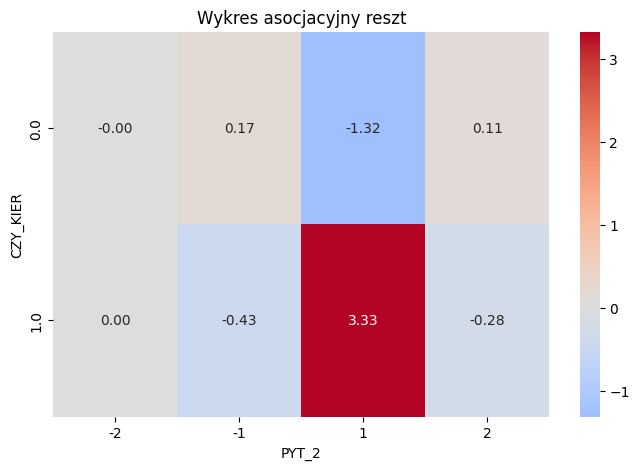

In [77]:
residuals = (contingency_table - expected) / np.sqrt(expected)

plt.figure(figsize=(8, 5))
sns.heatmap(residuals, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Wykres asocjacyjny reszt")
plt.xlabel("PYT_2")
plt.ylabel("CZY_KIER")
plt.show()

Wnioski:
P-wartość jest poniżej zakładanego poziomu 0.05 co oznacza, że odrzucamy hipotezę zerową i obserwujemy zależność. Wartości dodatnie heatmapy, np. w punkcie (1.0, 1), gdzie wartość wynosi 3.33 wskazują, że dana kombinacja występuje częściej niż przewidywano. W tym przypadku oznacza to, że najczęściej pojawiającą się kombinacją było "zgadzam się" wśród osób o stanowisku kierowniczym. Natomiast odpowiedzi "zgadzam się" u osób bez stanowiska kierowniczego występowały wyraźnie rzadziej niż zakładała hipoteza. Z kolei punkty bliskie zeru nie odbiegają znacząco od oczekiwanych wartości.


### **Zadanie 9**

Porównujemy test Fishera z testem chi-kwadrat.

In [78]:
p_matrix = np.array([[1/40, 3/40], [19/40, 17/40]])

def generate_data(n, p_matrix):
    data = np.random.multinomial(n, p_matrix.flatten()).reshape(2, 2)
    return data

n_values = [50, 100, 1000]
for n in n_values:
    data = generate_data(n, p_matrix)
    fisher_p_value = st.fisher_exact(data)[1]
    chi2_p_value = st.chi2_contingency(data)[1]
    print(f"n = {n}: Test Fishera p = {fisher_p_value:.4f}, Test chi-kwadrat p = {chi2_p_value:.4f}")

n = 50: Test Fishera p = 0.0511, Test chi-kwadrat p = 0.0730
n = 100: Test Fishera p = 0.1785, Test chi-kwadrat p = 0.2020
n = 1000: Test Fishera p = 0.0000, Test chi-kwadrat p = 0.0000


Wnioski: Im większy rozmiar próby, tym testy są skuteczniejsze. Test Fishera jest dokładniejszy od testu chi-kwadrat przy mniejszych próbkach.

### **Zadanie 10**

Definiujemy funkcję, która oblicza wartość poziomu krytycznego w teście niezależności opartym na na ilorazie wiarogodności.

In [79]:
def log_likelihood_p_value(board):
    p_value = st.chi2_contingency(board, lambda_="log-likelihood")[1] #parametr log-likelihood wskazuje na użycie ilorazu wiarogodności
    return p_value

In [80]:
contingency_table = pd.crosstab(df["CZY_KIER_NUM"], df["PYT_2"])
p_value = log_likelihood_p_value(contingency_table)
print("P-wartość:", p_value)

P-wartość: 0.039689561667618375


Wnioski: W teście opartym na ilorazie wiarogodności p-wartość wynosi ok. 0.0397, nieznacznie większą wartość uzyskaliśmy w zadaniu ósmym, jednak obie metody prowadzą do odrzucenia hipotezy zerowej o niezależności danych.

## **Część IV i V**

### **Zadanie 11**

Badamy związek pomiędzy paleniem papierosów a ́smiercią z powodu raka płuc oraz związek pomiędzy paleniem
papierosów a śmiercią z powodu choroby serca.

In [81]:
# Data
p_lung_cancer_smokers = 0.00140
p_lung_cancer_nonsmokers = 0.00010
p_heart_disease_smokers = 0.00669
p_heart_disease_nonsmokers = 0.00413

difference_lung_cancer = p_lung_cancer_smokers - p_lung_cancer_nonsmokers
difference_heart_disease = p_heart_disease_smokers - p_heart_disease_nonsmokers

relative_risk_lung_cancer = p_lung_cancer_smokers / p_lung_cancer_nonsmokers
relative_risk_heart_disease = p_heart_disease_smokers / p_heart_disease_nonsmokers

odds_ratio_lung_cancer = (p_lung_cancer_smokers / (1 - p_lung_cancer_smokers)) / (p_lung_cancer_nonsmokers / (1 - p_lung_cancer_nonsmokers))
odds_ratio_heart_disease = (p_heart_disease_smokers / (1 - p_heart_disease_smokers)) / (p_heart_disease_nonsmokers / (1 - p_heart_disease_nonsmokers))

print(f"Różnica proporcji (rak płuc): {difference_lung_cancer:.6f}")
print(f"Różnica proporcji (choroba serca): {difference_heart_disease:.6f}")
print(f"Ryzyko względne (rak płuc): {relative_risk_lung_cancer:.2f}")
print(f"Ryzyko względne (choroba serca): {relative_risk_heart_disease:.2f}")
print(f"Iloraz szans (rak płuc): {odds_ratio_lung_cancer:.2f}")
print(f"Iloraz szans (choroba serca): {odds_ratio_heart_disease:.2f}")

Różnica proporcji (rak płuc): 0.001300
Różnica proporcji (choroba serca): 0.002560
Ryzyko względne (rak płuc): 14.00
Ryzyko względne (choroba serca): 1.62
Iloraz szans (rak płuc): 14.02
Iloraz szans (choroba serca): 1.62


Różnica proporcji pokazuje, że palenie zwiększa ryzyko śmierci zarówno z powodu raka płuc, jak i choroby serca. Ryzyko względne dla raka płuc jest większe, co wskazuje, że palenie papierosów zwiększa ryzyko raka płuc bardziej niż choroby serca. Iloraz szans także wskazuje na silniejszy związek między paleniem a rakiem płuc. Możemy zatem wyciągnąć wnioski, że palenie papierosów ma silniejszy wpływ na ryzyko raka płuc niż na ryzyko choroby serca.

### **Zadanie 12**

Zajmujemy się wyznaczeniem odpowiednich wartości prawdopodobieństwa warunkowego, różnicy proporcji, ryzyka względnego i ilorazu szans. 

In [82]:
fatal_no_seatbelt = 1085
nonfatal_no_seatbelt = 55623
fatal_seatbelt = 703
nonfatal_seatbelt = 441239

### a)

In [83]:
p_fatal_no_seatbelt = fatal_no_seatbelt / (fatal_no_seatbelt + nonfatal_no_seatbelt)
p_fatal_seatbelt = fatal_seatbelt / (fatal_seatbelt + nonfatal_seatbelt)
print(f"Warunkowe prawdopodobieństwo śmierci bez pasów: {p_fatal_no_seatbelt:.6f}")
print(f"Warunkowe prawdopodobieństwo śmierci z pasami: {p_fatal_seatbelt:.6f}")

Warunkowe prawdopodobieństwo śmierci bez pasów: 0.019133
Warunkowe prawdopodobieństwo śmierci z pasami: 0.001591


### b)

In [84]:
p_seatbelt_fatal = fatal_seatbelt / (fatal_seatbelt + fatal_no_seatbelt)
p_seatbelt_nonfatal = nonfatal_seatbelt / (nonfatal_seatbelt + nonfatal_no_seatbelt)
print(f"Warunkowe prawdopodobieństwo użycia pasów wśród ofiar śmiertelnych: {p_seatbelt_fatal:.3f}")
print(f"Warunkowe prawdopodobieństwo użycia pasów wśród osób, które przeżyły: {p_seatbelt_nonfatal:.3f}")

Warunkowe prawdopodobieństwo użycia pasów wśród ofiar śmiertelnych: 0.393
Warunkowe prawdopodobieństwo użycia pasów wśród osób, które przeżyły: 0.888


### c)

In [85]:
difference_proportion = p_fatal_no_seatbelt - p_fatal_seatbelt
relative_risk = p_fatal_no_seatbelt / p_fatal_seatbelt
odds_ratio = (p_fatal_no_seatbelt / (1 - p_fatal_no_seatbelt)) / (p_fatal_seatbelt / (1 - p_fatal_seatbelt))

print(f"Różnica proporcji: {difference_proportion:.6f}")
print(f"Ryzyko względne: {relative_risk:.2f}")
print(f"Iloraz szans: {odds_ratio:.2f}")

Różnica proporcji: 0.017542
Ryzyko względne: 12.03
Iloraz szans: 12.24


Wnioski: Gdy prawdopodobieństwo zdarzenia jest niskie, iloraz szans dobrze aproksymuje ryzyko względne. W tym przypadku śmiertelność jest stosunkowo rzadka, więc wartości względnego ryzyka i Ilorazu szans są sobie bliskie.

### **Zadanie 13**

Współczynnik tau Kendalla mierzy siłę i kierunek zależności między zmiennymi porządkowymi. Wartość bliska 1 oznacza silną dodatnią korelację, bliska -1 oznacza silną ujemną korelację, a bliska 0 wskazuje na brak istotnej zależności.

In [86]:
tau_pyt2_kier, p_value_tau_pyt2_kier = st.kendalltau(df["PYT_2"], df["CZY_KIER"])
print(f"Współczynnik tau Kendalla dla stopnia zadowolenia i stanowiska: {tau_pyt2_kier:.3f}, p-value: {p_value_tau_pyt2_kier:.3f}")
tau_pyt2_staz, p_value_tau_pyt2_staz = st.kendalltau(df["PYT_2"], df["STAŻ"])
print(f"Współczynnik tau Kendalla dla stopnia zadowolenia i stażu pracy: {tau_pyt2_staz:.3f}, p-value: {p_value_tau_pyt2_staz:.3f}")
tau_kier_staz, p_value_tau_kier_staz = st.kendalltau(df["CZY_KIER"], df["STAŻ"])
print(f"Współczynnik tau Kendalla dla stanowiska i stażu pracy: {tau_kier_staz:.3f}, p-value: {p_value_tau_kier_staz:.3f}")

Współczynnik tau Kendalla dla stopnia zadowolenia i stanowiska: -0.013, p-value: 0.849
Współczynnik tau Kendalla dla stopnia zadowolenia i stażu pracy: 0.048, p-value: 0.467
Współczynnik tau Kendalla dla stanowiska i stażu pracy: 0.282, p-value: 0.000


Wnioski: Nie wykryto istotnej zależności między stopniem zadowolenia, a stanowiskiem kierowniczym, p-wartość = 0.849 oznacza, że nie mamy podstaw do odrzucenia hipotezy o braku zależności. Współczynnik tau jest również blisku zeru w przypadku stopnia zadowolenia i stażu pracy. Jeżeli chodzi o stanowisko i staż pracy, wykryto średnią dodatnią zależność, która jest statystycznie istotna.

### **Zadanie 14**

Dokonujemy analizy korespondencji dla danych dotyczących stopnia zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie oraz stażu pracy.

In [87]:
table = pd.crosstab(df["PYT_2"], df["STAŻ"])
display(table)

STAŻ,1,2,3
PYT_2,,,
-2,20,45,9
-1,3,17,0
1,0,0,2
2,18,78,8


In [88]:
def correspondence_analysis(table, n_components=2):
    # Konwersja tabeli na tablicę NumPy i obliczenie częstości względnych
    table = np.array(table, dtype=np.float64)
    total = np.sum(table)
    P = table / total  # Prawdopodobieństwa obserwacji

    # Profile wierszy i kolumn (suma prawdopodobieństw)
    r = np.sum(P, axis=1)
    c = np.sum(P, axis=0)

    # Obliczenie oczekiwanych częstości jako iloczyn profili
    expected = np.outer(r, c)

    # Macierze diagonalne do skalowania
    Dr_inv_sqrt = np.diag(1 / np.sqrt(r))
    Dc_inv_sqrt = np.diag(1 / np.sqrt(c))

    # Obliczenie zcentralizowanej macierzy reszt (standaryzowanych różnic)
    S = Dr_inv_sqrt @ (P - expected) @ Dc_inv_sqrt

    # Rozkład SVD macierzy S
    U, s, Vt = np.linalg.svd(S, full_matrices=False)

    # Obliczenie wartości własnych oraz inercji (wyjaśnionej wariancji)
    eigenvalues = s**2
    inertia = eigenvalues / np.sum(eigenvalues)

    # Standardowe współrzędne wierszy i kolumn: U * s i V * s (przy czym V = Vt.T)
    F = U[:, :n_components] * s[:n_components]
    G = Vt.T[:, :n_components] * s[:n_components]

    # Aby uzyskać współrzędne główne (principal coordinates) zgodne z prince.CA,
    # dodatkowo skaluje się wyniki przez macierze odwrotnych pierwiastków z profili.
    F_principal = np.diag(1/np.sqrt(r)) @ F
    G_principal = np.diag(1/np.sqrt(c)) @ G

    # Uporządkowanie wyników do postaci DataFrame
    row_index = [f"{i}" for i in range(table.shape[0])]
    col_index = [f"{j}" for j in range(table.shape[1])]
    row_coords_df = pd.DataFrame(F_principal, index=row_index, columns=[0, 1])
    col_coords_df = pd.DataFrame(G_principal, index=col_index, columns=[0, 1])

    # Wizualizacja wyników
    plt.figure(figsize=(8, 6))
    # Wiersze
    plt.scatter(row_coords_df[0], row_coords_df[1], c='red', label='Stopień zadowolenia')
    # Kolumny
    plt.scatter(col_coords_df[0], col_coords_df[1], c='blue', label='Staż')

    # Dodanie etykiet przy punktach
    for idx, point in row_coords_df.iterrows():
        plt.text(point[0], point[1] + 0.02, f"Row{idx}", color='red')
    for idx, point in col_coords_df.iterrows():
        plt.text(point[0], point[1] + 0.02, f"Col{idx}", color='blue')

    # Dodanie pionowej linii przerywanej przy x=0 oraz poziomej przy y=0
    plt.axvline(x=0, linestyle='--', color='gray')
    plt.axhline(y=0, linestyle='--', color='gray')

    plt.title('Analiza korespondencji - związek pomiędzy poziomem zadowolenia, a stażem')
    plt.xlabel('Wymiar 1')
    plt.ylabel('Wymiar 2')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return row_coords_df, col_coords_df, eigenvalues, inertia

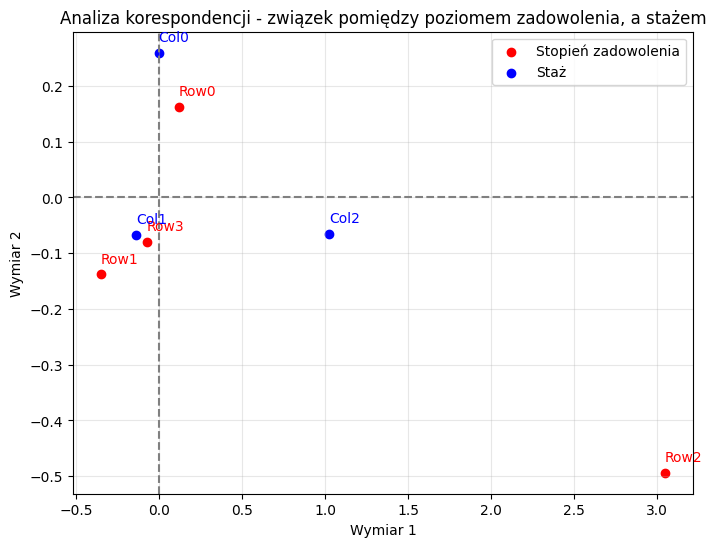

(          0         1
 0  0.118266  0.162227
 1 -0.350562 -0.137860
 2  3.046727 -0.493733
 3 -0.075326 -0.079425,
           0         1
 0 -0.003061  0.259435
 1 -0.138246 -0.067150
 2  1.025261 -0.065046,
 array([1.13240431e-01, 1.73561387e-02, 3.10310148e-34]),
 array([8.67101113e-01, 1.32898887e-01, 2.37609724e-33]))

In [89]:
correspondence_analysis(table)

Wnioski: Im bliżej siebie są punkty, tym bardziej są ze sobą powiązane. Wymiary reprezentują kierunki zmienności w danych. Występuje zależność między stażem, a poziomem zadowolenia ze szkoleń. Najczęściej zadowolenie wykazują osoby ze średnim stażem, a niezadowolenie te z najmniejszym stażem.